In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

from rayopt import *

np.set_printoptions(precision=3)

Populating the interactive namespace from numpy and matplotlib


In [2]:
description = "oslo cooke triplet example 50mm f/4 20deg"
columns = "type roc distance radius material"
text = """
O 0       0     .364 AIR
S 21.25   5     6.5  SK16
S -158.65 2     6.5  AIR
S -20.25  6     5    F4
S 19.3    1     5    AIR
A 0       0     4.75 AIR
S 141.25  6     6.5  SK16
S -17.285 2     6.5  AIR
I 0       42.95 .364 AIR
"""

_description = "triplet 50mm f/4 20deg"
_columns = "type curvature distance radius material"
_text = """
O 0         0  .364 AIR
S .25285    5   1.8 1.62
S -.01474  .6   1.8 AIR
S -.1994 1.0654 1.3 1.621
S .25973  .15   1.3 AIR
A 0        .1   1.1 AIR
S .05065 1.0396 1.7 1.62
S -.24588  .6   1.7 AIR
I 0   8.27937     2 AIR
"""

_description = "photo triplet, f/2.7, f=100 U.S.-Pat 2,453,260 (1948-Pestrecov)"
_columns = "type distance roc diameter material"
_text = """
O 0      0   .25 AIR
S 20 40.94    20 1.617/55
S 8.74   0    20 AIR
S 11.05 -55.65 20 1.649/33.8
S 2.78 39.75  20 AIR
A 0      0    30 AIR
S 7.63 107.56 30 1.617/55
S 9.54 -43.33 30 AIR
I 79.34  0    30 AIR
"""

_description="cooke type triplet, USP 2453260 Pestrecov, Modern Optical Engineering, Smith"
_columns = "type roc distance radius material"
_text = """
    O      0     0   .3 AIR
    S  40.94    10   16 S-BSM9
    S      0  8.74   16 AIR
    S -55.65 10.05   14 S-TIM22
    A      0  2.78   12 S-TIM22
    S  39.75     0   14 AIR
    S 107.56  7.63 14.5 S-BSM9
    S -43.33  9.54 14.5 AIR
    I      0    90    0 AIR
"""

s = system_from_text(text, columns.split(),
    description=description)
s.object.angle = np.deg2rad(20)

s = system_from_yaml("""
description: "code v cooke triplet example 50mm f/4.5 20deg"
stop: 3
object: {angle_deg: 20, pupil: {radius: 5.55}}
elements:
- {material: air, radius: 10}
- {distance: 4, material: SCHOTT/SK16, roc: 21.48138, radius: 7}
- {distance: 2, material: air, roc: -124.1, radius: 7}
- {distance: 5.26, material: HOYA/F4, roc: -19.1, radius: 4.1}
- {distance: 1.25, material: air, roc: 22, radius: 4.1}
- {distance: 4.69, material: SCHOTT/SK16, roc: 328.9, radius: 7}
- {distance: 2.25, material: air, roc: -16.7, radius: 7}
- {distance: 43.050484, material: air}
""")

s = system_from_yaml("""
description: "smith triplet p444, 100mm f/8 23.4deg"
stop: 4
object: {angle_deg: 23.4, pupil: {radius: 6.25}}
elements:
- {material: air, radius: 20}
- {distance: 10, material: SCHOTT/SK4, roc: 40.1, radius: 17}
- {distance: 6, material: air, roc: -537.1, radius: 17}
- {distance: 10, material: SCHOTT/FN11, roc: -47.0, radius: 15}
- {distance: 1, material: air, roc: 40, radius: 15}
- {distance: 10.8, material: SCHOTT/SK4, roc: 234.5, radius: 16}
- {distance: 6, material: air, roc: -37.9, radius: 16}
- {distance: 85.3, material: air, radius: 45}
""")
s.update()
s.paraxial.focal_length_solve(100)
s.paraxial.update()
s.paraxial.refocus()

print(s)
#s.reverse()
#print(s)

KeyError: 'material None/None/sk16 not found'

In [3]:
a = Analysis(s, refocus_full=False)

NameError: name 's' is not defined

In [4]:
class GeomOp(Operand):
    def __init__(self, system, rays=13, *args, **kwargs):
        super(GeomOp, self).__init__(system, *args, **kwargs)
        self.t = [GeometricTrace(self.system) for f in self.system.fields]
        self.rays = rays

    def get(self):
        for t, f in zip(self.t, self.system.fields):        
            t.rays_point((0, f), nrays=self.rays,
                         distribution="radau",
                         clip=False, filter=False)
        # for t, f in zip(self.t, self.system.fields):
        #     t.propagate()
        v = np.concatenate([
                (t.y[-1, 1:, :2] - t.y[-1, t.ref, :2])/np.sqrt(t.y.shape[1])
                for t in self.t])
        return np.where(np.isfinite(v), v, 10).ravel()


class PolyOp(Operand):
    def __init__(self, system, kmax=3, *args, **kwargs):
        super(PolyOp, self).__init__(system, *args, **kwargs)
        self.t = PolyTrace(self.system, kmax=kmax)
    
    def get(self):
        self.t.propagate()
        return self.t.stvwof[-1, :2, 1:].ravel()


s1 = system_from_yaml(system_to_yaml(s))
s1[1].material = s[5].material = Library.one().get("material", "LAK33")
s1[3].material = Library.one().get("material", "BASF2")
#s1.stop = 3
#s1.aperture.radius *= 1.5
s1.object.pupil.radius *= 1.5
s1.update()
variables = []
variables.extend(PathVariable(s1, (i, "distance"), (1, 6))
                 for i in (2, 4, 6))
variables.extend(PathVariable(s1, (i, "distance"), (.1, 15))
                 for i in (3, 5))
variables.extend(PathVariable(s1, (i, "curvature"), (-1/20, 1/20))
                 for i in (1, 2, 3, 4, 5))

def get(s):
    s.update()
    s.paraxial.focal_length_solve(100)
    s.paraxial.propagate(start=-2)
    s.paraxial.refocus()
    s.paraxial.propagate(start=-1)
    s.paraxial.resize()
    s.paraxial.aberrations()

operands = [
    FuncOp(s1, get),
    FuncOp(s1, lambda s: s[-1].offset[2:], min=60),
    FuncOp(s1, lambda s: s.edge_thickness()[1:], min=2),
    #FuncOp(s1, lambda s: np.diff(s.track), min=2),
    FuncOp(s1, lambda s: s.paraxial.transverse3[:, 5:].sum(0)/.5, min=-1, max=1),
    FuncOp(s1, lambda s: s.paraxial.transverse3[:, 3:5].sum(0)/1, min=-1, max=1),
    FuncOp(s1, lambda s: s.paraxial.transverse3[:, :3].sum(0)/.03, min=-1, max=1),
    #FuncOp(s1, lambda s: s.paraxial.transverse3[:, (0, 1, 2, 5, 6)].sum(0), weight=1),
    GeomOp(s1, rays=13, weight=1),
    #PolyOp(s1, weight=1),
]

r = optimize(variables, operands, trace=True, tol=1e-4, options=dict( \
        maxiter=100, disp=True, eps=1e-5, iprint=2))
r.accept()
print(s1)

NameError: name 's' is not defined

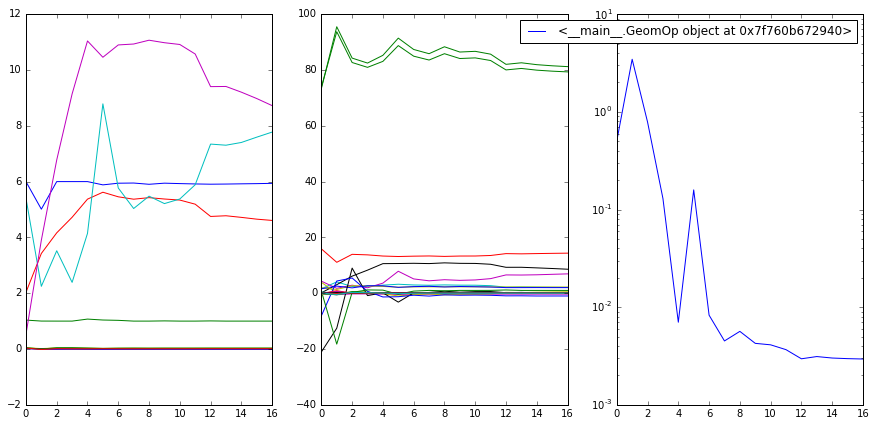

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax[0].plot(r.trace_x)
for i in range(len(r.trace_v[0])):
    ax[1].plot([_[i] for _ in r.trace_v])
for i, _ in r.trace_f:
    ax[2].semilogy(np.square(_).sum(-1), label=str(operands[i]))
ax[2].legend()

/home/rj/work/nist/pyrayopt/rayopt/paraxial_trace.py:186: RuntimeWarning: divide by zero encountered in true_divide
  return self.n[(0, -2), ]/(2*na)
/home/rj/work/nist/pyrayopt/rayopt/paraxial_trace.py:191: RuntimeWarning: divide by zero encountered in true_divide
  return 1.22*self.wavelength/(2*na)/self.system.scale
/home/rj/work/nist/pyrayopt/rayopt/elements.py:208: RuntimeWarning: invalid value encountered in less_equal
  good = np.square(y[:, :2]).sum(1) <= self.radius**2


System: smith triplet p444, 100mm f/8 23.4deg
Scale: 1.0 mm
Wavelengths: 588, 656, 486 nm
Fields: 0, 0.7, 1
Object:
 Semi-Angle: 23.4 deg
 Pupil:
   Pupil Distance: 25.5827
   Refractive Index: 1.00028
   Radius: 9.375
Image:
 Radius: 45
 Pupil:
   Pupil Distance: -93.2576
   Refractive Index: 1.00028
   Update Radius: True
   Radius: 8.7429
Stop: 4
Elements:
 # T   Distance   Rad Curv   Diameter          Material       n      nd      Vd
 0 S          0        inf         40         basic/air   1.000   1.000   89.30
 1 S         10      32.88     32.694      SCHOTT/LAK33   1.754   1.754   52.43
 2 S     5.9373      184.6     27.127         basic/air   1.000   1.000   89.30
 3 S     7.7749     -82.93     15.205      SCHOTT/BASF2   1.664   1.664   35.83
 4 S          1      30.96     14.357         basic/air   1.000   1.000   89.30
 5 S     8.7232      110.2     25.118        SCHOTT/SK4   1.613   1.613   58.63
 6 S     4.6083      -53.7     28.245         basic/air   1.000   1.000   89.3

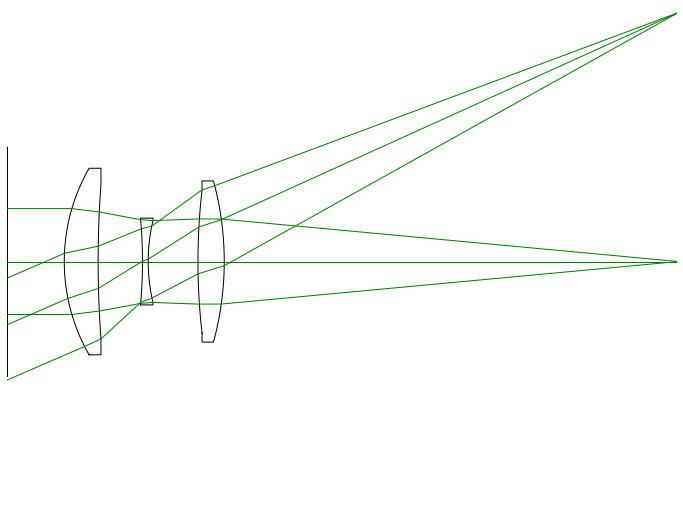

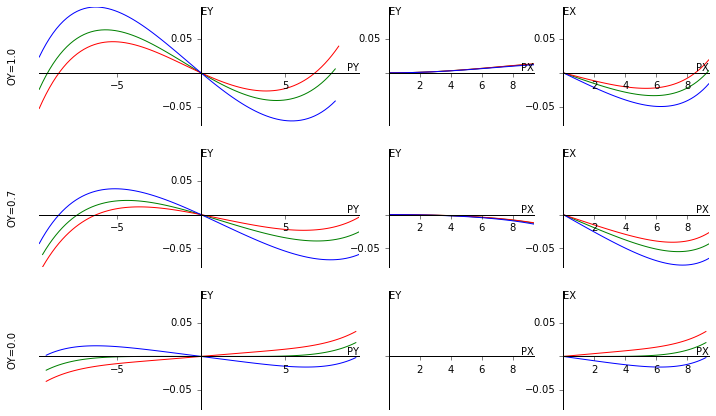

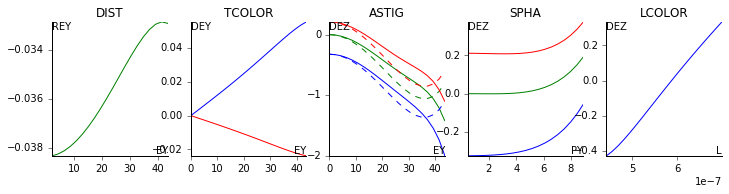

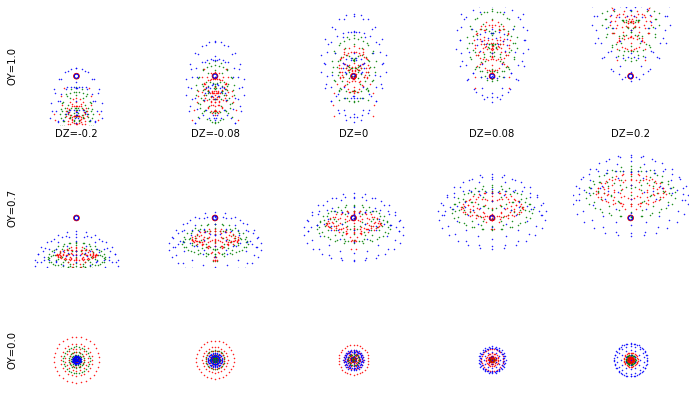

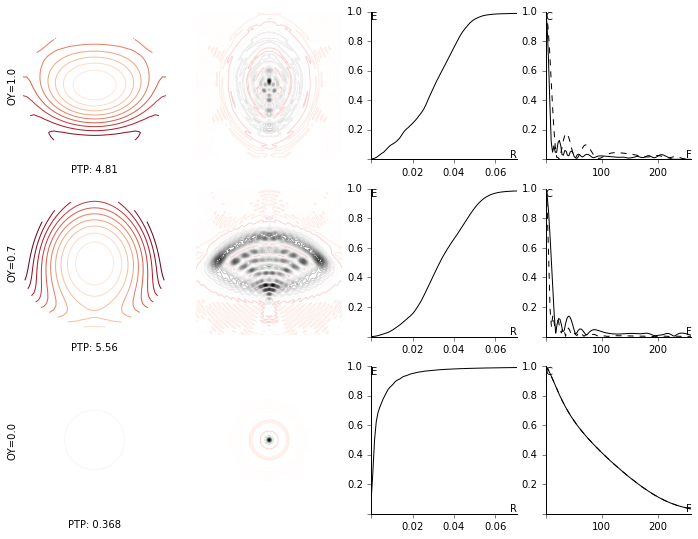

In [6]:
Analysis(s1, refocus_full=False)

[ 0.09  0.09] (array([ 0.09+0.996j,  0.09+0.996j]), array([ 0.09-0.996j,  0.09-0.996j])) [ True  True] [ True  True]
[[ 0.5    0.5  ]
 [ 0.5    0.5  ]
 [ 0.472  0.472]
 [ 0.39   0.39 ]
 [ 0.388  0.388]
 [ 0.421  0.421]
 [ 0.426  0.426]
 [ 0.027  0.027]]
(array([[ 0.5  ,  0.5  ],
       [ 0.5  ,  0.5  ],
       [ 0.472,  0.472],
       [ 0.39 ,  0.39 ],
       [ 0.388,  0.388],
       [ 0.421,  0.421],
       [ 0.426,  0.426],
       [ 0.027,  0.027]]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]))
 # T      path    spot a    spot b  spot ang waistx dz waisty dz   waist x   waist y
 0 S         0       0.5       0.5         0         0         0       0.5       0.5
 1 S        10       0.5       0.5         0     105.4     105.4   0.02447   0.02447
 2 S        16    0.4716    0.4716         0      57.6      57.6   0.02286   0.02286
 3 S        26      0.39      0.39         0     204.4     204.4   0.06124   0.06124
 4 S        27    0.3881    0.3881         0    -125.9    -125.9   0.

/home/rj/work/nist/pyrayopt/rayopt/elements.py:570: RuntimeWarning: divide by zero encountered in true_divide
  s = .5*y*n0*(1 - mu)/l*(i + u/n)
/home/rj/work/nist/pyrayopt/rayopt/elements.py:570: RuntimeWarning: invalid value encountered in true_divide
  s = .5*y*n0*(1 - mu)/l*(i + u/n)
/home/rj/work/nist/pyrayopt/rayopt/elements.py:571: RuntimeWarning: invalid value encountered in double_scalars
  w = 4*k*n*(1 - mu)/l
/home/rj/work/nist/pyrayopt/rayopt/elements.py:583: RuntimeWarning: invalid value encountered in double_scalars
  dc = s[1]*i[0]*i[1] + .5*(u[1]**2/n**2 - u0[1]**2/n0**2) + \
/home/rj/work/nist/pyrayopt/rayopt/elements.py:586: RuntimeWarning: invalid value encountered in true_divide
  tachc, tchc = -y[0]*i/l*(v0 - mu*v)


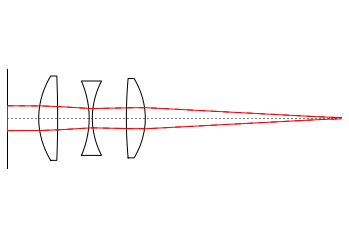

In [7]:
from rayopt import GaussianTrace
s.object = FiniteConjugate(radius=.5)
g = GaussianTrace(s)
g.is_proper()
print(g.m, g.eigenvalues, g.real, g.stable)
g.refocus()
#qi = g.qi[0]
#g.qi[0, 0] *= 2
#qi[0, 1] = qi[1, 0] = 1e-2-1e-5j
#g.rays(qi)
#g.propagate()
#print g.qi[-1]
r = g.spot_radius_at(None)
print(r)
print(g.spot_radius_at(z=None, normal=True))
#print 1/g.qi.real
#print g.eigenmodes
#g.rays(np.eye(2)*g.eigenmodes[0])

g.propagate()
#print g.qi
print(g)
print(g.spot_radius)

fig, ax = plt.subplots()
s.plot(ax)
g.plot(ax, color="red", waist=True, scale=10)
#ax.set_xlim(0, 70)
#ax.set_ylim(-5, .5)
ax.set_aspect("auto")
plt.show()